In [1]:
import polars as pl
import plotly.graph_objects as go
import plotly.express as px
from sklearn.metrics import confusion_matrix
import numpy as np
from PIL import Image
from pathlib import Path

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [3]:
import torch
from torchvision import models
from torch import nn
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
def create_cm(y_true, y_pred, labels=None, save_path=None, display=False):
    cm = confusion_matrix(y_true, y_pred)
    if labels:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    else:
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    if save_path:
        disp.figure_.savefig(save_path)
    if display:
        plt.show()
    return cm

In [5]:
def create_report(y_true, y_pred, labels=None, save_path=None, display=False):
    if labels:
        report = classification_report(y_true, y_pred, target_names=labels)
    else:
        report = classification_report(y_true, y_pred)
    if save_path:
        with open(save_path, "w") as f:
            f.write(report)
    if display:
        print(report)
    return report

In [6]:
def load_checkpoint(path):
    checkpoint = torch.load(
        path,
        map_location=device
    )
    return checkpoint

In [7]:
class FaceDataset(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df["face_path"].to_list()
        self.labels = df["label"].to_list()
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        if self.transform:
            img = self.transform(img)

        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return img, label

In [8]:
def run_eval(checkpoint, df):
    model = models.resnet18(weights="IMAGENET1K_V1")
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.to(device)
    model.eval()

    for param in model.parameters():
        param.requires_grad = False

    eval_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225],
        )
    ])

    ds_loader = create_loader(df, transform=eval_transform)

    y_true, y_pred = run_prediction(ds_loader, model)
    return y_true, y_pred

In [9]:
def create_loader(df, transform):
    ds = FaceDataset(df, transform)
    ds_loader = DataLoader(ds, batch_size=32, shuffle=False)
    return ds_loader

In [10]:
def run_prediction(ds_loader, model):
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for x, y in ds_loader:
            x = x.to(device)
            out = model(x)
            preds = out.argmax(dim=1).cpu().numpy()
    
            y_pred.extend(preds)
            y_true.extend(y.numpy())
    
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return y_true, y_pred

## Paths 

In [11]:
fv_base_dir = Path('../models/pixabay_light_aug_v2/')
raf_base_dir = Path('../models/raf_db')

In [12]:
val_file = 'val_predictions.parquet'
model_file = 'model.pt'

In [13]:
image_dir = Path('../images')

In [14]:
fv_df = pl.read_parquet(fv_base_dir / val_file)
raf_df = pl.read_parquet(raf_base_dir / val_file)

In [15]:
fv_checkpoint = load_checkpoint(fv_base_dir / model_file)
raf_checkpoint = load_checkpoint(raf_base_dir / model_file)

## Verify matching mappings

In [16]:
fv_checkpoint['label_map']

{'angry': 0, 'fear': 1, 'happy': 2, 'sad': 3, 'surprise': 4}

In [17]:
raf_checkpoint['label_map']

{'angry': 0, 'fear': 1, 'happy': 2, 'sad': 3, 'surprise': 4}

In [18]:
emotion_list = fv_checkpoint["emotions"]
label_map = fv_checkpoint["label_map"]
num_classes = len(emotion_list)
print(emotion_list)

['angry', 'fear', 'happy', 'sad', 'surprise']


In [19]:
fv_true = fv_df['true_label'].to_numpy()
fv_pred = fv_df['pred_label'].to_numpy()

In [20]:
raf_true = raf_df['true_label'].to_numpy()
raf_pred = raf_df['pred_label'].to_numpy()

In [21]:
train_data = pl.read_parquet('../configs/aggregation_mixing/pixabay_v2.parquet')
train_data.shape

(2132, 24)

In [22]:
train_data['emotion'].value_counts()

emotion,count
str,u32
"""fear""",233
"""angry""",166
"""surprise""",203
"""sad""",542
"""happy""",988


## FV Val Metrics 

In [23]:
create_report(fv_true, fv_pred, labels=emotion_list, save_path=None, display=True)

              precision    recall  f1-score   support

       angry       0.58      0.74      0.65        34
        fear       0.47      0.40      0.44        47
       happy       0.83      0.81      0.82       197
         sad       0.65      0.73      0.69       109
    surprise       0.62      0.45      0.52        40

    accuracy                           0.71       427
   macro avg       0.63      0.63      0.62       427
weighted avg       0.71      0.71      0.70       427



'              precision    recall  f1-score   support\n\n       angry       0.58      0.74      0.65        34\n        fear       0.47      0.40      0.44        47\n       happy       0.83      0.81      0.82       197\n         sad       0.65      0.73      0.69       109\n    surprise       0.62      0.45      0.52        40\n\n    accuracy                           0.71       427\n   macro avg       0.63      0.63      0.62       427\nweighted avg       0.71      0.71      0.70       427\n'

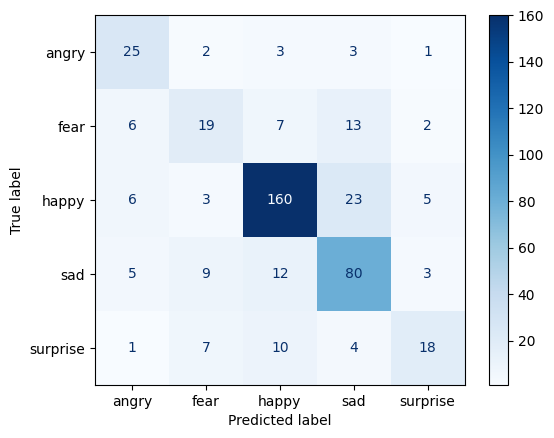

array([[ 25,   2,   3,   3,   1],
       [  6,  19,   7,  13,   2],
       [  6,   3, 160,  23,   5],
       [  5,   9,  12,  80,   3],
       [  1,   7,  10,   4,  18]])

In [24]:
save_path = image_dir / "fv_val_cm.png"
create_cm(fv_true, fv_pred, labels=emotion_list, save_path=save_path, display=True)

## RAF Test Metrics

In [25]:
raf_test_path = Path('../data/raf-db/DATASET/raf_test_trimmed.parquet')
raf_test_df = pl.read_parquet(raf_test_path)
raf_test_df.head()

data_source,face_path,emotion
str,str,str
"""raf-db""","""../data/raf-db/DATASET/test/sa…","""sad"""
"""raf-db""","""../data/raf-db/DATASET/test/sa…","""sad"""
"""raf-db""","""../data/raf-db/DATASET/test/sa…","""sad"""
"""raf-db""","""../data/raf-db/DATASET/test/sa…","""sad"""
"""raf-db""","""../data/raf-db/DATASET/test/sa…","""sad"""


In [26]:
raf_test_df = raf_test_df.with_columns(
    pl.col("emotion").replace_strict(label_map, default=None).alias('label')
)
raf_test_df.head()

data_source,face_path,emotion,label
str,str,str,i64
"""raf-db""","""../data/raf-db/DATASET/test/sa…","""sad""",3
"""raf-db""","""../data/raf-db/DATASET/test/sa…","""sad""",3
"""raf-db""","""../data/raf-db/DATASET/test/sa…","""sad""",3
"""raf-db""","""../data/raf-db/DATASET/test/sa…","""sad""",3
"""raf-db""","""../data/raf-db/DATASET/test/sa…","""sad""",3


In [27]:
fv_raf_test_true, fv_raf_test_pred = run_eval(checkpoint=fv_checkpoint, df=raf_test_df)

In [28]:
create_report(fv_raf_test_true, fv_raf_test_pred, labels=emotion_list, save_path=None, display=True)

              precision    recall  f1-score   support

       angry       0.25      0.41      0.31       162
        fear       0.03      0.32      0.06        74
       happy       0.76      0.53      0.63      1185
         sad       0.52      0.37      0.44       478
    surprise       0.86      0.11      0.20       329

    accuracy                           0.42      2228
   macro avg       0.49      0.35      0.33      2228
weighted avg       0.66      0.42      0.48      2228



'              precision    recall  f1-score   support\n\n       angry       0.25      0.41      0.31       162\n        fear       0.03      0.32      0.06        74\n       happy       0.76      0.53      0.63      1185\n         sad       0.52      0.37      0.44       478\n    surprise       0.86      0.11      0.20       329\n\n    accuracy                           0.42      2228\n   macro avg       0.49      0.35      0.33      2228\nweighted avg       0.66      0.42      0.48      2228\n'

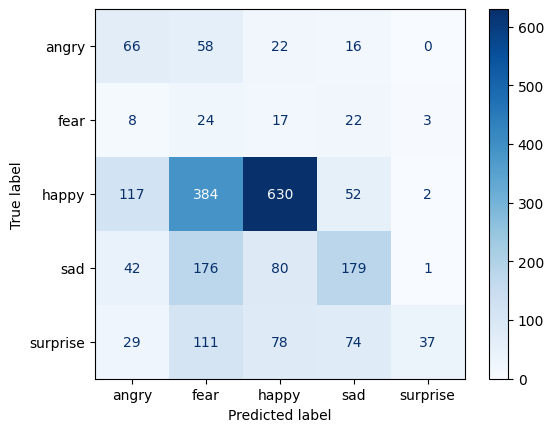

array([[ 66,  58,  22,  16,   0],
       [  8,  24,  17,  22,   3],
       [117, 384, 630,  52,   2],
       [ 42, 176,  80, 179,   1],
       [ 29, 111,  78,  74,  37]])

In [29]:
save_path = image_dir / "fv_raf_test_cm.png"
create_cm(fv_raf_test_true, fv_raf_test_pred, labels=emotion_list, save_path=save_path, display=True)

In [30]:
raf_raf_test_true, raf_raf_test_pred = run_eval(checkpoint=raf_checkpoint, df=raf_test_df)

In [31]:
create_report(raf_raf_test_true, raf_raf_test_pred, labels=emotion_list, save_path=None, display=True)

              precision    recall  f1-score   support

       angry       0.78      0.83      0.80       162
        fear       0.64      0.50      0.56        74
       happy       0.91      0.97      0.94      1185
         sad       0.95      0.76      0.84       478
    surprise       0.82      0.90      0.86       329

    accuracy                           0.89      2228
   macro avg       0.82      0.79      0.80      2228
weighted avg       0.89      0.89      0.88      2228



'              precision    recall  f1-score   support\n\n       angry       0.78      0.83      0.80       162\n        fear       0.64      0.50      0.56        74\n       happy       0.91      0.97      0.94      1185\n         sad       0.95      0.76      0.84       478\n    surprise       0.82      0.90      0.86       329\n\n    accuracy                           0.89      2228\n   macro avg       0.82      0.79      0.80      2228\nweighted avg       0.89      0.89      0.88      2228\n'

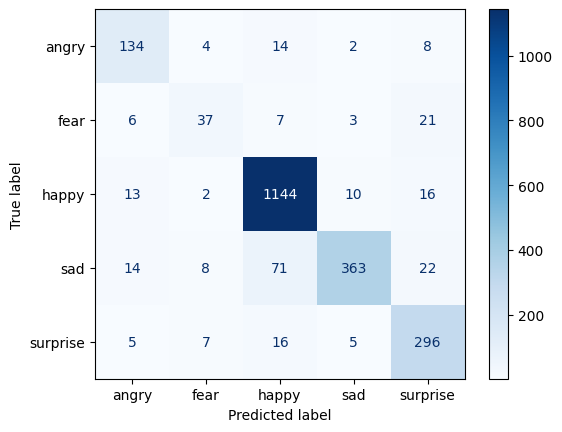

array([[ 134,    4,   14,    2,    8],
       [   6,   37,    7,    3,   21],
       [  13,    2, 1144,   10,   16],
       [  14,    8,   71,  363,   22],
       [   5,    7,   16,    5,  296]])

In [32]:
save_path = image_dir / "raf_raf_test_cm.png"
create_cm(raf_raf_test_true, raf_raf_test_pred, labels=emotion_list, save_path=save_path, display=True)